## Описание данных

**Ссылка на датсет:** https://www.kaggle.com/datasets/angelosgiotis/consumers-bid

Предложенный датасет для работы состоить из двух частей:
- Набор данных **"Consumers"** включает изображения розничных потребителей, снятые с помощью RGB-камер, и их реальные координаты в виде bound box.
- Набор данных **"BID"** состоит из обрезанных изображений полного тела потребителей с аннотациями, а также реальной информацией об их возрасте и поле.

В данной работе использован только набор данных **"Consumers"**, тк. ее целью является только под щхет количества людей в магазине.

Следовательно, в рботе будет обучена модель детекции, а иоговое количество людей в магазине будем определять подсчетом объектов, которые модель успела детектировать.

## Загрузка данных

Струдктура используемого набора данных представлена на картике:

![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F17922636%2F064ee2e51239f2c5b0a5e38685689be4%2FConsumersSmall.png?generation=1701373217319160&alt=media)

где *gt.txt* содержит полную информацию об аннотациях `[frame_id, consumer_id, bounding-box]` для всей последовательности, для использования в алгоритме детекции.

Каждый файл frameID.txt содержит информацию об аннотациях `[consumer_ID, bounding_box_coords ((x, y, width, height)), age_group ,gender]` для каждого аннотированного экземпляра в кадре. Данная инфромация в нашей работе использоваться не будет.


In [1]:
# установка и загрузка библиотек
!pip install kagglehub

In [2]:
!pip install torch torchvision albumentations

In [3]:
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import numpy as np
import csv

import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Subset
import random

import kagglehub

In [4]:
# загрузка датасета с Kaggle
path = kagglehub.dataset_download("angelosgiotis/consumers-bid")

print("Path to dataset files:", path)

100%|██████████| 850M/850M [00:09<00:00, 97.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/angelosgiotis/consumers-bid/versions/6


In [5]:
class ConsumersGTDataset(Dataset):
    """
    Набор данных Consumers. Каждая папка содержит изображения и файл `gt/gt.txt`.
        Структура:
          root/
            Sequence_ID000/
              img_00001.jpg
              img_00002.jpg
              gt/
                gt.txt
            Sequence_ID001/
              ...
    Формат gt.txt (без заголовка), каждая строка:
    photo_id, consumer_id, x_top_left, y_top_left, width, height
    Координаты предполагаются как левый верхний угол (x, y, width, height).
    photo_id может включать расширение или быть просто идентификатором кадра.
    """

    def __init__(self, root, sequences=None, transform=None,
                 img_extensions=('.jpg', '.jpeg', '.png'), try_find=True):
        self.root = Path(root)
        if not self.root.exists():
            raise FileNotFoundError(f"Root path does not exist: {self.root}")
        self.transform = transform
        self.img_extensions = tuple(e.lower() for e in img_extensions)
        self.try_find = try_find

        # список sequences для загрузки
        if sequences is None:
            sequences = sorted([p.name for p in self.root.iterdir() if p.is_dir()])
        self.sequences = sequences

        # mapping image_path -> список аннотаций
        self._anns = {}  # Path -> список (consumer_id, cx, cy, w, h, normalized_flag_guess)
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            gt_path = seq_dir / 'gt' / 'gt.txt'
            if not gt_path.exists():
                # sequences без файла gt не рассматрывем
                continue
            # парсим gt file
            with open(gt_path, 'r', encoding='utf-8') as f:
                first = f.readline()
                if ',' in first:
                    delimiter = ','
                else:
                    delimiter = None
            with open(gt_path, 'r', encoding='utf-8') as f:
                if delimiter:
                    reader = csv.reader(f, delimiter=delimiter)
                else:
                    reader = csv.reader(f, delimiter=None, skipinitialspace=True)
                for row in reader:
                    if not row:
                        continue
                    row = [r.strip() for r in row if r is not None and str(r).strip() != '']
                    if len(row) < 6:
                        continue
                    photo_id_raw = row[0]
                    try:
                        consumer_id = int(row[1])
                        x_tl = float(row[2])
                        y_tl = float(row[3])
                        w_box = float(row[4])
                        h_box = float(row[5])
                    except Exception:
                        continue


                    img_path = self._resolve_image_path(seq_dir, photo_id_raw)
                    if img_path is None:
                        if self.try_find:
                            img_path = self._fuzzy_find(seq_dir, photo_id_raw)
                    if img_path is None:
                        continue


                    normalized_guess = (0.0 <= x_tl <= 1.0 and 0.0 <= y_tl <= 1.0 and 0.0 <= w_box <= 1.0 and 0.0 <= h_box <= 1.0)

                    key = str(img_path.resolve())
                    self._anns.setdefault(key, []).append((consumer_id, x_tl, y_tl, w_box, h_box, normalized_guess))

        # Создаем элементы: включаем все файлы изображений в sequence-ах
        # даже если у них нет аннотаций (для них мы вернем пустые target-ы)
        items = []
        for seq in self.sequences:
            seq_dir = self.root / seq
            if not seq_dir.exists() or not seq_dir.is_dir():
                continue
            for p in sorted(seq_dir.iterdir()):
                if p.is_file() and p.suffix.lower() in self.img_extensions:
                    items.append(p)
        self.items = [p.resolve() if isinstance(p, Path) else Path(p).resolve() for p in items]

    def _resolve_image_path(self, seq_dir: Path, photo_id_raw: str):

        pid = photo_id_raw
        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p

        p = seq_dir / pid
        if p.exists() and p.is_file():
            return p

        if not Path(pid).suffix:
            for ext in self.img_extensions:
                candidate = seq_dir / (pid + ext)
                if candidate.exists():
                    return candidate

        name = Path(pid).name
        p = seq_dir / name
        if p.exists():
            return p
        return None

    def _fuzzy_find(self, seq_dir: Path, photo_id_raw: str):
        pid = photo_id_raw.lower()
        for p in seq_dir.rglob('*'):
            if p.is_file() and p.suffix.lower() in self.img_extensions:
                if pid in p.name.lower():
                    return p
        return None

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path = self.items[idx]
        ann_list = self._anns.get(str(img_path.resolve()), [])
        img = Image.open(img_path).convert('RGB')
        w_img, h_img = img.size

        boxes = []
        ids = []
        for (cid, x_tl, y_tl, w_box, h_box, normalized_guess) in ann_list:
            if normalized_guess:
                # нормализованные координаты, преобразуем в пиксели
                x_px = x_tl * w_img
                y_px = y_tl * h_img
                w_px = w_box * w_img
                h_px = h_box * h_img
            else:
                x_px, y_px, w_px, h_px = x_tl, y_tl, w_box, h_box

            # (x_px,y_px,w_px,h_px) -> x1,y1,x2,y2
            x1 = x_px
            y1 = y_px
            x2 = x_px + w_px
            y2 = y_px + h_px

            x1 = max(0.0, x1)
            y1 = max(0.0, y1)
            x2 = min(float(w_img), x2)
            y2 = min(float(h_img), y2)

            if x2 <= x1 or y2 <= y1:
                continue

            boxes.append([x1, y1, x2, y2])
            ids.append(int(cid))

        if boxes:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            ids = torch.tensor(ids, dtype=torch.long)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            ids = torch.tensor([], dtype=torch.long)

        target = {
            'boxes': boxes,
            'ids': ids,
            'image_id': torch.tensor([idx]),
            'file_path': str(img_path)
        }

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        return img, target

In [6]:
def collate_detection(batch):

    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]

    try:
        images = torch.stack(images, dim=0)
    except Exception:
        pass
    return images, targets

Show image No.350 with 1 bound boxes


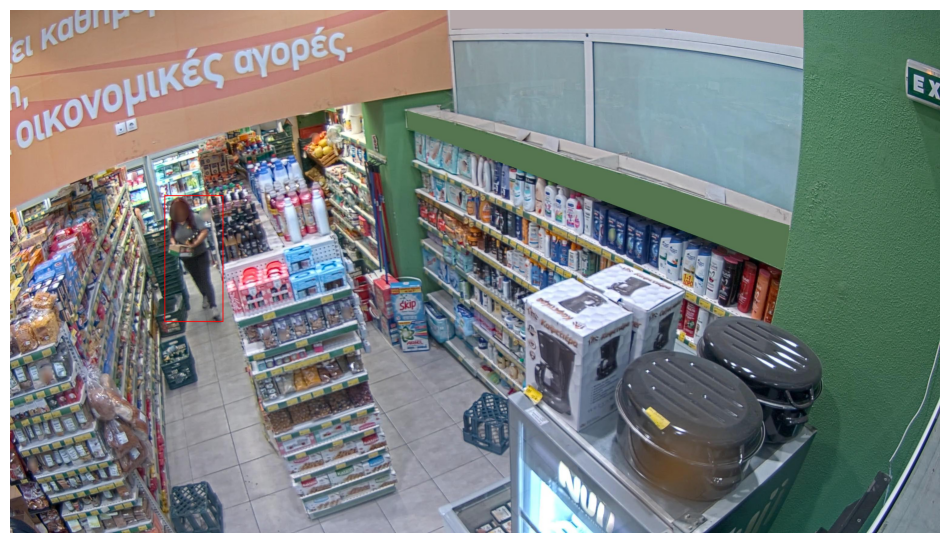

In [7]:
# Теперь создам датасет и визуализуализируем изображение с bound box для произвольного индекса

dataset_root = Path(path) / 'Consumers' if 'path' in globals() else Path('path/to/dataset_root')
dataset = ConsumersGTDataset(root=dataset_root, transform=None)

def visualize_idx(dataset, idx, figsize=(12,8), show=True):
    img_tensor, target = dataset[idx]
    fp = target.get('file_path', None)

    if fp is not None and Path(fp).exists():
      pil_img = Image.open(fp).convert('RGB')
    else:
      pil_img = ToPILImage()(img_tensor)

    draw = ImageDraw.Draw(pil_img)
    boxes = target.get('boxes')
    ids = target.get('ids')
    if boxes is not None and boxes.numel() > 0:
        boxes_np = boxes.detach().cpu().numpy()
        ids_np = ids.detach().cpu().numpy() if ids is not None and ids.numel() > 0 else [None]*len(boxes_np)
        for b, cid in zip(boxes_np, ids_np):
            x1,y1,x2,y2 = b
            draw.rectangle([x1, y1, x2, y2], outline='red', width=3)
            label = str(int(cid)) if cid is not None else ''

            text_pos = (max(0, x1), max(0, y1-12))
            draw.text(text_pos, label, fill='yellow')
    if show:
        plt.figure(figsize=figsize)
        plt.imshow(pil_img)
        plt.axis('off')
    return pil_img, target

# Визуализируем первый элемент
if len(dataset) == 0:
  print('Dataset пустой — необходимо изменить путь `dataset_root` или проверить наличие gt/gt.txt в sequence папках')
else:
  idx = 350
  pil_img, target = visualize_idx(dataset, idx)
  print(f'Show image No.{idx} with', target.get('boxes').shape[0], 'bound boxes')

### Преобразование данных (аугментации)

In [8]:
# Определим аугментации, которые будем использовать на данных

train_alb = A.Compose([
    A.HorizontalFlip(p=0.5),
    #A.Resize(480, 854)
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5, border_mode=0),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.0))

val_alb = A.Compose([
    #A.Resize(480, 854)
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.0))

def make_collate(alb_transform):
    to_tensor = ToTensor()
    def collate_fn(batch):
        images_out = []
        targets_out = []
        for img_tensor, target in batch:
            fp = target.get('file_path', None)
            boxes = target.get('boxes')
            ids = target.get('ids')
            if boxes is None or boxes.numel() == 0:
                bboxes = []
                labels = []
            else:
                bboxes = boxes.detach().cpu().numpy().tolist()
                labels = ids.detach().cpu().numpy().tolist()

            if fp is not None and Path(fp).exists():
                # open original image (PIL) to apply albumentations in pixel coords
                pil = Image.open(fp).convert('RGB')
                img_np = np.array(pil)
                try:
                    aug = alb_transform(image=img_np, bboxes=bboxes, labels=labels)
                    img_np = aug['image']
                    bboxes = aug.get('bboxes', [])
                    labels = aug.get('labels', [])
                except Exception:
                    # if augmentation fails (e.g., wrong bbox format), fallback to original
                    img_np = np.array(pil)
            else:
                # No file path: try to use provided tensor (already transformed) — convert to PIL then to numpy
                try:
                    pil = ToPILImage()(img_tensor)
                    img_np = np.array(pil)
                    aug = alb_transform(image=img_np, bboxes=bboxes, labels=labels) if alb_transform is not None else {'image':img_np,'bboxes':bboxes,'labels':labels}
                    img_np = aug['image']
                    bboxes = aug.get('bboxes', [])
                    labels = aug.get('labels', [])
                except Exception:
                    # fallback: convert tensor directly
                    img_np = img_tensor.detach().cpu().numpy().transpose(1,2,0)

            # convert to tensor
            img_t = to_tensor(img_np)
            images_out.append(img_t)

            if bboxes:
                boxes_t = torch.tensor(bboxes, dtype=torch.float32)
                ids_t = torch.tensor(labels, dtype=torch.long)
            else:
                boxes_t = torch.zeros((0,4), dtype=torch.float32)
                ids_t = torch.tensor([], dtype=torch.long)

            new_target = {'boxes': boxes_t, 'ids': ids_t, 'image_id': target.get('image_id', torch.tensor([-1])), 'file_path': target.get('file_path')}
            targets_out.append(new_target)

        # try stacking images (may fail if shapes differ)
        try:
            images_out = torch.stack(images_out, dim=0)
        except Exception:
            pass
        return images_out, targets_out
    return collate_fn

# Split indices helper
def split_indices(dataset, val_ratio=0.2, seed=42):
    n = len(dataset)
    idx = list(range(n))
    rnd = random.Random(seed)
    rnd.shuffle(idx)
    split = int(n*(1-val_ratio))
    return idx[:split], idx[split:]

# Build base dataset (no transform here; collate will handle resizing/augmentation)
base_ds = ConsumersGTDataset(root=dataset_root, transform=None)
train_idx, val_idx = split_indices(base_ds, val_ratio=0.2, seed=42)
train_base = Subset(base_ds, train_idx)
val_base = Subset(base_ds, val_idx)

train_loader = DataLoader(train_base, batch_size=16, shuffle=True, num_workers=4, collate_fn=make_collate(train_alb), pin_memory=True)
val_loader = DataLoader(val_base, batch_size=8, shuffle=False, num_workers=4, collate_fn=make_collate(val_alb), pin_memory=True)

print('Sizes — all:', len(base_ds), 'train:', len(train_base), 'val:', len(val_base))

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Sizes — all: 1466 train: 1172 val: 294


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


#### Резюме для дальнейшей работы:

- Создан класс `ConsumersGTDataset` для загрузки изображений и bbox.
- Для аугментаций есть трансформации `train_alb` и `val_alb`.
- Функция `visualize_idx(dataset, idx)` показывает изображение с нарисованными bounding-box и id.